In [177]:
import pandas as pd
import sqlite3
from sklearn.base import BaseEstimator, TransformerMixin
import nltk
import string
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.externals import joblib
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix, ROCAUC, ClassBalance

In [178]:
with sqlite3.connect('data/pitchfork.sqlite') as con:
    pf_scores = pd.read_sql_query('select reviewid, score from reviews', con)
    pf_content = pd.read_sql_query('select * from content', con)

In [179]:
result = pd.merge(pf_scores, pf_content, on='reviewid')

# result = result[:4500]

# result['score'] = np.digitize(result.score, [0.0, 3.0, 5.0, 7.0, 10.0])

booldict = {0: 'Bad', 1:'OK', 2:'Good', 3:'Great'}
# result['score'] = np.digitize(result.score, [3.0, 5.0, 7.0, 11]) BEFORE
result['score'] = np.digitize(result.score, [6.5, 7.3, 7.9, 10.1]) # after
result['score'] = result.score.map(booldict)

print(result[result['score'] == 'Bad'].shape)
print(result[result['score'] == 'OK'].shape)
print(result[result['score'] == 'Good'].shape)
print(result[result['score'] == 'Great'].shape)

# 6.8, 7.5, 8.0, 10.1 Good Balance
# 6.8, 7.2, 7.8, 10.1



(4670, 3)
(4626, 3)
(4652, 3)
(4453, 3)


In [180]:
X_train, X_test, y_train, y_test = train_test_split(result.content, result.score, test_size=0.20, random_state=42)

In [181]:
class TextNormalizer(BaseEstimator, TransformerMixin):
    """ remove punctuation, remove stopwords, and lemmatize """
    
    def __init__(self):
        self.wnl = WordNetLemmatizer()
        self.stopwords = nltk.corpus.stopwords.words('english')
        
    def fit(self, x, y=None):
        return self
    
    def normalize(self, review):
        return [self.wnl.lemmatize(word) 
                for word in review.split()
                if word not in set(self.stopwords)
               ]

    def transform(self, documents):
        reviews = [ re.sub('[^a-z\s]', '', doc.lower())
                   for doc in documents]
        return [
            ' '.join(self.normalize(review)) for review in reviews
        ] 

In [182]:
pipeline = Pipeline([
    ('normalize', TextNormalizer()),
    ('text', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

In [183]:
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('normalize', TextNormalizer()), ('text', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', prepr...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [184]:
joblib.dump(pipeline, 'clf_pitchfork.xz', compress=('xz', 9))

['clf_pitchfork.xz']

In [185]:
y_pred = pipeline.predict(X_test)

In [186]:
accuracy = accuracy_score(y_pred=y_pred, y_true=y_test)

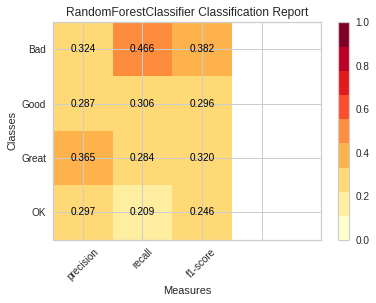

In [187]:
visualizer = ClassificationReport(pipeline)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

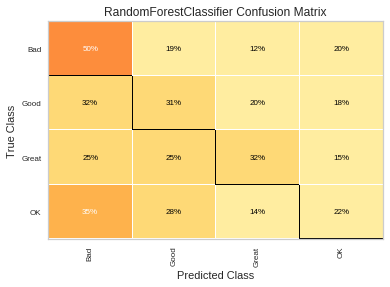

In [188]:
cm = ConfusionMatrix(pipeline)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)
cm.poof()

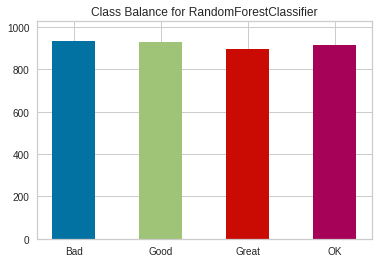

In [189]:
visualizer = ClassBalance(pipeline)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
g=visualizer.poof()